<a href="https://colab.research.google.com/github/DWalicki95/MaterialsVision/blob/main/notebooks/cellpose_finetuned_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/DWalicki95/MaterialsVision.git

fatal: destination path 'MaterialsVision' already exists and is not an empty directory.


In [55]:
# !pip install cellpose

In [3]:
import os

os.environ['PYTHONPATH'] = (
  '/content/MaterialsVision:' + os.environ.get('PYTHONPATH', '')
)

In [4]:
from pathlib import Path
import numpy as np
from cellpose.io import imread
import tifffile
import time

from cellpose import models, io, plot
from cellpose.metrics import (
    mask_ious, boundary_scores, aggregated_jaccard_index, average_precision
)
import torch
from skimage.segmentation import relabel_sequential
from cellpose.metrics import boundary_scores
from cellpose import utils
import gc
import pandas as pd
from typing import Dict, List
import json
import matplotlib.pyplot as plt

from datetime import datetime

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
dataset_path = Path(
    '/home/ubuntu/test_40_50'
  )

In [7]:
def remove_temp_files(ds_path):
  ds = []
  for file in ds_path.rglob('*'):
    if str(file.name).startswith('.'):
      continue
    ds.append(file)
  return ds

In [8]:
def get_image_from_store(prefix: str = '_image', n_samples=10):
  images = []
  files = remove_temp_files(test_path)
  for f in files:
    if prefix in str(f):
      images.append(imread(f))
      if (n_samples == -1):
        continue
      if len(images) >= n_samples:
        return images
  return images

# Model evaluation

In [56]:
def get_bbox_from_mask(mask: np.ndarray, relabel_image: bool = True) -> dict:
  if relabel_image:
    mask, forward, inverse_map = relabel_sequential(mask, offset=1)
  labels = np.unique(mask)
  bboxes = {}
  for label in labels[labels>0]:
    rows, cols = np.where(mask==label)
    if rows.size == 0:
      continue
    y_min, y_max = rows.min(), rows.max()
    x_min, x_max = cols.min(), cols.max()
    bboxes[int(label)] = int(x_min), int(y_min), int(x_max), int(y_max)
  return bboxes

In [57]:
def get_n_pores_from_mask(mask: np.ndarray):
  labels = np.unique(mask)
  n_pores = len(labels) - (1 if 0 in labels else 0)
  return n_pores

In [58]:
def calculate_iou(bbox_true, bbox_pred, epsilon=1e-5):
  # coordinates of the intersection box
  x1 = np.max([bbox_true[0], bbox_pred[0]])
  y1 = np.max([bbox_true[1], bbox_pred[1]])
  x2 = np.min([bbox_true[2], bbox_pred[2]])
  y2 = np.min([bbox_true[3], bbox_pred[3]])

  # area of overlap
  width = (x2 - x1)
  height = (y2 - y1)

  # if there is no overlap
  if (width<0) or (height<0):
    return 0.0
  area_of_overlap = width * height
  # combined area
  area_bbox_true = (bbox_true[2] - bbox_true[0]) * (bbox_true[3] - bbox_true[1])
  area_bbox_pred = (bbox_pred[2] - bbox_pred[0]) * (bbox_pred[3] - bbox_pred[1])
  area_combined = area_bbox_true + area_bbox_pred - area_of_overlap
  # ratio of area of overlap over combined area
  iou = area_of_overlap / (area_combined + epsilon)
  return iou

In [59]:
def get_iou_matrix(bboxes_true, bboxes_pred):
  n_bboxes_true = len(bboxes_true)
  n_bboxes_pred = len(bboxes_pred)
  I = np.zeros((n_bboxes_true, n_bboxes_pred), dtype=np.float32)
  for i in range(n_bboxes_true):
    for j in range(n_bboxes_pred):
      I[i, j] = calculate_iou(bboxes_true[i], bboxes_pred[j])
  return I

In [60]:
def calculate_pores_difference(n_pores_true: int, n_pores_pred):
  return float(np.abs(n_pores_true - n_pores_pred) / n_pores_true)

In [61]:
def greedy_match_iou(iou_matrix, threshold):
  I = iou_matrix.copy()
  all_triples_list = []
  matched_true, matched_pred = set(), set()
  matches = []
  I[I < threshold] = 0.0
  N_true, N_pred = I.shape
  # get pores difference
  pores_diff = calculate_pores_difference(N_true, N_pred)

  non_zero = np.argwhere(I>0.0)
  for (i, j) in non_zero:
    all_triples_list.append((i, j, I[i, j]))

  sorted_all_triples_list = sorted(
      all_triples_list, key=lambda x: x[2], reverse=True
  )

  for triples in sorted_all_triples_list:
    if (triples[0] not in matched_true) & (triples[1] not in matched_pred):
      matched_true.add(triples[0])
      matched_pred.add(triples[1])
      matches.append((triples[0], triples[1], triples[2]))

  TP = len(matches)
  FN = N_true - len(matched_true)
  FP = N_pred - len(matched_pred)

  precision = (TP / (TP + FP) if (TP + FP) > 0 else 0.0)
  recall = (TP / (TP + FN) if (TP+FN) > 0 else 0.0)
  f1_score = (2 * (precision * recall) / (precision + recall) if
      (precision + recall) > 0 else 0.0
  )
  iou_mean = float(sum(score for (_, _, score) in matches) / TP if TP > 0 else 0.0)

  return {
      'TP': TP,
      'FP': FP,
      'FN': FN,
      'precision': precision,
      'recall': recall,
      'f1_score': f1_score,
      'iou_mean': iou_mean,
      'pores_diff': pores_diff
  }


In [62]:
def iou_scores_batch(true_masks, pred_masks, greedy_match_threshold = 0.5):
  iou_results = {}
  for idx, (true_mask, pred_mask) in enumerate(zip(true_masks, pred_masks)):
    pred_bboxes = get_bbox_from_mask(pred_mask)
    true_bboxes = get_bbox_from_mask(true_mask)
    iou_matrix = get_iou_matrix(
        list(pred_bboxes.values()), list(true_bboxes.values())
    )
    one_img_output = greedy_match_iou(iou_matrix, greedy_match_threshold)
    iou_results[idx] = one_img_output
  return iou_results

In [63]:
def boundary_scores_batched(masks_true, masks_pred, scales, batch_size=2):
    N = len(masks_true)
    M = len(scales)

    precision_all = np.zeros((M, N), dtype=float)
    recall_all    = np.zeros((M, N), dtype=float)
    fscore_all    = np.zeros((M, N), dtype=float)

    for start in range(0, N, batch_size):
        end = min(start + batch_size, N)
        # part of lists (batched solution)
        sub_true = masks_true[start:end]
        sub_pred = masks_pred[start:end]
        p_sub, r_sub, f_sub = boundary_scores(sub_true, sub_pred, scales)

        precision_all[:, start:end] = p_sub
        recall_all[:, start:end]    = r_sub
        fscore_all[:, start:end]    = f_sub

        # clean memory
        gc.collect()

    return precision_all, recall_all, fscore_all


In [64]:
def summarize_evaluation_iou(iou_results):
    TP_all, FP_all, FN_all = [], [], []
    micro_metrics = ['TP', 'FP', 'FN']
    
    # Identify macro metrics
    macro_metrics_list = [
        metric for metric in list(iou_results.values())[0].keys()
        if metric not in micro_metrics
    ]
    
    # Initialize collectors for macro metrics
    macro_values = {metric: [] for metric in macro_metrics_list}
    
    # Collect values from all images
    for metric_dict in iou_results.values():
        for metric, value in metric_dict.items():
            if metric in macro_metrics_list:
                macro_values[metric].append(value)
            elif metric == 'TP':
                TP_all.append(value)
            elif metric == 'FP':
                FP_all.append(value)
            elif metric == 'FN':
                FN_all.append(value)
    
    # Calculate macro averages
    macro_metric_results = {}
    for metric, values in macro_values.items():
        macro_metric_results[f'iou_mean_{metric}'] = np.mean(values)
    
    # Calculate micro metrics
    TP_all_sum = np.sum(TP_all)
    FP_all_sum = np.sum(FP_all)
    FN_all_sum = np.sum(FN_all)
    
    precision_micro = TP_all_sum / (TP_all_sum + FP_all_sum) if (TP_all_sum + FP_all_sum) > 0 else 0
    recall_micro = TP_all_sum / (TP_all_sum + FN_all_sum) if (TP_all_sum + FN_all_sum) > 0 else 0
    f1_micro = (
        2 * precision_micro * recall_micro
    ) / (precision_micro + recall_micro) if (precision_micro + recall_micro) > 0 else 0
    
    # Prepare final report
    report = pd.DataFrame.from_dict(
        macro_metric_results, orient='index', columns=['value']
    )
    report.loc['iou_precision_micro'] = precision_micro
    report.loc['iou_recall_micro'] = recall_micro
    report.loc['iou_f1_micro'] = f1_micro
    
    return report

In [65]:
def summarize_evaluation_boundary_score(precision_all, recall_all, fscore_all):
  bs_precision_mean = np.mean(precision_all)
  bs_recall_mean = np.mean(recall_all)
  bs_fscore_mean = np.mean(fscore_all)
  bs_metrics_dict = {
        'boundary_score_mean_precision': bs_precision_mean,
        'boundary_score_mean_recall':    bs_recall_mean,
        'boundary_score_mean_f1':        bs_fscore_mean,
  }
  report = pd.DataFrame.from_dict(
      bs_metrics_dict, orient='index', columns=['value']
  )
  return report

In [66]:
def get_today_datetime_str():
  today_datetime = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
  today_datetime = today_datetime[:-3]  # skip seconds
  today_datetime = (
      today_datetime
      .replace('-', '_')
      .replace(':', '_')
      .replace('/', '_')
      .replace(' ', '__')
  )
  return today_datetime

In [67]:
def summarize_evaluation(
    output_filename: str,
    model_params: Dict,
    evaluating_duration: float,
    iou_results: Dict,
    boundary_score_precision_all: List,
    boundary_score_recall_all: List,
    boundary_score_fscore_all: List,
    evaluation_comment: str = '',
    save_raw_iou_results: bool = True,
    save_final_results: bool = True,
    output_directory_path = None,
    add_today_datetime_to_filename: bool = True
):
  report_iou = summarize_evaluation_iou(iou_results)
  report_boundary_score = summarize_evaluation_boundary_score(
      precision_all=boundary_score_precision_all,
      recall_all=boundary_score_recall_all,
      fscore_all=boundary_score_fscore_all
  )
  report_final = pd.concat([report_iou, report_boundary_score])
  report_final['comment'] = evaluation_comment
  report_final['model_params'] = [model_params] * len(report_final)
  report_final['evaluation_duration'] = evaluating_duration
  # save files
  today_datetime_str = (
      get_today_datetime_str() if add_today_datetime_to_filename else ''
  )
  if not output_directory_path:
    output_directory_path = Path(
        '/content/drive/MyDrive/evaluation_metrics'
    )
  # save raw iou
  if save_raw_iou_results:
    output_directory_path.mkdir(parents=True, exist_ok=True)
    output_filename = (
        f'raw_iou_results_{evaluation_comment}_{today_datetime_str}.json'
    )
    output_filepath = output_directory_path / output_filename
    with open(output_filepath, 'w') as f:
      json.dump(iou_results, f)
    print('Raw iou test dictionary saved.')
  # save final results
  if save_final_results:
    output_directory_path.mkdir(parents=True, exist_ok=True)
    output_filename = (
        f'evaluation_results_{today_datetime_str}.csv'
    )
    output_filepath = output_directory_path / output_filename
    report_final.to_csv(output_filepath)
    print('Final evaluation metrics report saved.')
    return report_final

In [68]:
def visualize_results(
    imgs,
    pred_masks,
    img_idx_to_visualize: int = 0,
    save_subsample: bool = True,
    output_directory_path = None,
    add_today_datetime_to_filename: bool = True,
    evaluation_comment: str = ''
):
  if not output_directory_path:
    output_directory_path = Path(
        '/content/drive/MyDrive/evaluation_metrics/plots'
    )
  today_datetime_str = (
      get_today_datetime_str() if add_today_datetime_to_filename else ''
  )
  # save images
  if save_subsample:
    output_directory_path.mkdir(parents=True, exist_ok=True)
    num_images = 10
    for img_idx in range(num_images):
        fig = plt.figure(figsize=(20, 12))
        plot.show_segmentation(
          fig=fig,
          maski=pred_masks[img_idx],
          img=imgs[img_idx],
          flowi=flows[img_idx][0]
        )
        plt.savefig(
            f'{output_directory_path}/{evaluation_comment}_figure_{img_idx}.jpg'
        )
        plt.close(fig)
  # show_figure
  fig = plt.figure(figsize=(20, 12))
  plot.show_segmentation(
    fig=fig,
    maski=pred_masks[img_idx_to_visualize],
    img=imgs[img_idx_to_visualize],
    flowi=flows[img_idx_to_visualize][0]
  )
  plt.show()

# Evaluation

In [69]:
from cellpose.io import imread
from skimage.io import imsave
import time

In [70]:
MODEL_PATH = '/home/ubuntu/model/cpsam-finetuned'

In [71]:
def get_img_mask_pairs(
    dataset_path,
    img_extension: str = '.jpg',
    img_suffix = 'image',
    mask_extension = '.tif',
    mask_suffix='masks',
    loaded: bool = False
  ):
    images = sorted(dataset_path.rglob(f'*{img_suffix}{img_extension}'))

    img_mask = {}

    for img_path in images:
        base_name = img_path.stem.replace(img_suffix, '')
        mask_path = (
            img_path.parent / f'{base_name}{mask_suffix}{mask_extension}')

        if mask_path.exists():
            img_mask[img_path] = mask_path

    if loaded:
        img_mask_list = []
        for img_path, mask_path in img_mask.items():
            base_name = img_path.stem
            if base_name.endswith(img_suffix):
                base_name = base_name[:-len(img_suffix)]

            img_mask_list.append({
                'base_name': base_name,
                'image': imread(str(img_path)),
                'true_mask': imread(str(mask_path))
            })
        return img_mask_list
    return img_mask

In [72]:
dataset = get_img_mask_pairs(dataset_path, loaded=True)

In [73]:
model = models.CellposeModel(
    gpu=True,
    diam_mean=None,
    pretrained_model=MODEL_PATH
  )


In [74]:
from pathlib import Path
from cellpose.io import imread, imsave
import numpy as np
import pickle

def process_dataset_with_cache(dataset, model, dataset_path, recompute=False):
    """
    Process dataset with Cellpose model and cache results to disk.

    Parameters:
    -----------
    dataset : list or iterable
        Dataset containing items with 'image' and 'base_name' keys
    model : Cellpose model
        Trained Cellpose model for evaluation
    dataset_path : Path or str
        Directory path where predictions will be saved/loaded
    recompute : bool, default=False
        If True, recompute even if cached files exist

    Returns:
    --------
    dataset : list
        Dataset with added 'pred_mask', 'flows', and 'styles' fields for each item
    """
    output_dir = Path(dataset_path)
    output_dir.mkdir(exist_ok=True, parents=True)

    for item in dataset:
        mask_file = output_dir / f"{item['base_name']}_predmask.tif"
        flows_file = output_dir / f"{item['base_name']}_flows.pkl"  # Changed to .pkl
        styles_file = output_dir / f"{item['base_name']}_styles.npy"

        # Check if prediction already exists on disk
        if mask_file.exists() and flows_file.exists() and not recompute:
            print(f"Loading cached prediction: {item['base_name']}")
            masks = imread(mask_file)

            # Load flows from pickle
            with open(flows_file, 'rb') as f:
                flows = pickle.load(f)

            # Load styles if exists
            if styles_file.exists():
                styles = np.load(styles_file, allow_pickle=True)
                item['styles'] = styles

            item['pred_mask'] = masks
            item['flows'] = flows

        else:
            # Compute prediction
            print(f"Computing prediction: {item['base_name']}")
            masks, flows, styles = model.eval(item['image'], diameter=None)

            item['pred_mask'] = masks
            item['flows'] = flows
            item['styles'] = styles

            # Save prediction
            imsave(mask_file, masks.astype('uint16'))

            # Save flows as pickle (handles complex structures)
            with open(flows_file, 'wb') as f:
                pickle.dump(flows, f)

            # Save styles
            np.save(styles_file, styles)

    return dataset

In [75]:
start = time.time()
full_dataset = process_dataset_with_cache(
    dataset=dataset,
    model=model,
    dataset_path=dataset_path,
    recompute=True
  )
duration = time.time() - start

Computing prediction: 0ab7de9d-AS2_40_10_jpg.rf.209a8405481b2434b8436c3f3acd60fd_test_0204_
Computing prediction: 20988eca-AS2_40_12_jpg.rf.2bead37e5a94b450eb0df42d79cba36a_test_0171_
Computing prediction: 323fe9f1-AS2_40_26_jpg.rf.a250fd33c005cfc804de61e95463f48d_test_0144_
Computing prediction: 3af27c05-AS2_40_28_jpg.rf.0e8c8e353cf21f813443cb9d565343c0_test_0123_
Computing prediction: AS10_40_11_jpg.rf.8b88c4959811b7e08f0bdef6f299ce43_test_0187_
Computing prediction: AS10_40_12_jpg.rf.3f43becb58558006d776d7bb0d2f02cf_test_0196_
Computing prediction: AS10_40_15_jpg.rf.394db6b715d5843b57780395a53db504_test_0170_
Computing prediction: AS10_40_20_jpg.rf.d5416c41572b713c0bef8b1f98476b6d_test_0011_
Computing prediction: AS10_40_25_jpg.rf.e64c502284a492475d30e7cc8093edfc_test_0118_
Computing prediction: AS10_40_2_jpg.rf.9f3e23b8d2a0803e11d5b4623c00b750_test_0161_
Computing prediction: AS10_40_31_jpg.rf.34e596103ad6f04428e51aef357d7856_test_0074_
Computing prediction: AS10_40_33_jpg.rf.77311

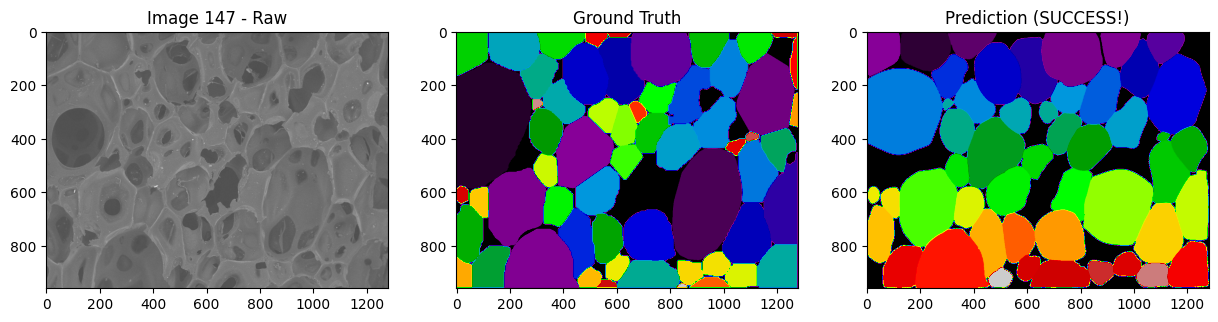

In [76]:
idx=147
# Visualize the successful image
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(dataset[idx]['image'])
plt.title('Image 147 - Raw')
plt.subplot(132)
plt.imshow(dataset[idx]['true_mask'], cmap='nipy_spectral')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(dataset[idx]['pred_mask'], cmap='nipy_spectral')
plt.title('Prediction (SUCCESS!)')
plt.show()

In [77]:
masks, flows, styles = model.eval(dataset[idx]['image'], diameter=None)


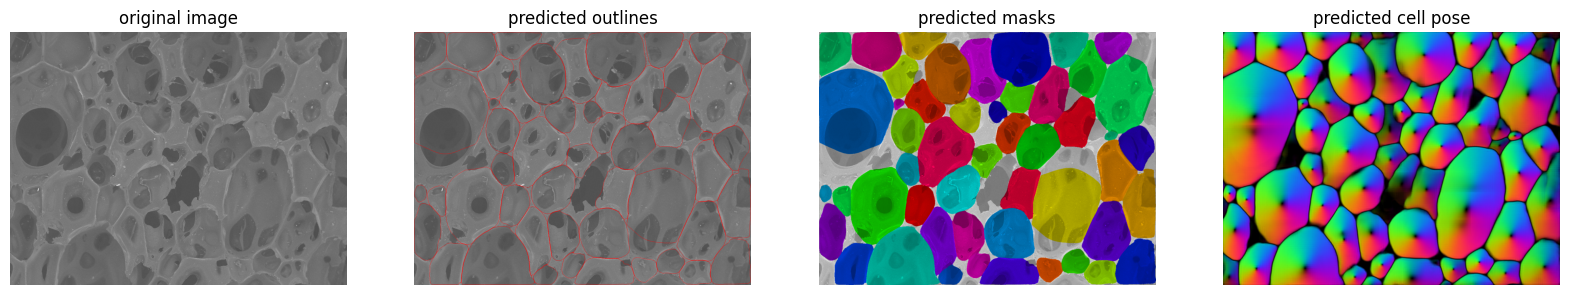

In [45]:
fig = plt.figure(figsize=(20, 12))
plot.show_segmentation(
  fig=fig,
  maski=masks,
  img=dataset[idx]['image'],
  flowi=flows[0]
)

In [ ]:
dsasa

In [78]:
true_masks = [x['true_mask'] for x in dataset]
pred_masks = [x['pred_mask'] for x in dataset]

In [79]:
iou_results = iou_scores_batch(
    true_masks=true_masks,
    pred_masks=pred_masks,
    greedy_match_threshold=0.5
)

/tmp/ipykernel_16100/2877411845.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return float(np.abs(n_pores_true - n_pores_pred) / n_pores_true)


In [80]:
def check_mask_shapes(true_masks, pred_masks):
    """Check for shape mismatches between true and predicted masks."""
    mismatches = []

    for i, (true_mask, pred_mask) in enumerate(zip(true_masks, pred_masks)):
        if true_mask.shape != pred_mask.shape:
            mismatches.append({
                'index': i,
                'true_shape': true_mask.shape,
                'pred_shape': pred_mask.shape
            })

    if mismatches:
        print(f"Found {len(mismatches)} shape mismatches:")
        for m in mismatches[:10]:  # Show first 10
            print(f"  Index {m['index']}: true={m['true_shape']}, pred={m['pred_shape']}")
    else:
        print("✓ All masks have matching shapes!")

    return mismatches

# Check your data
mismatches = check_mask_shapes(true_masks, pred_masks)

✓ All masks have matching shapes!


In [81]:
import numpy as np

def align_mask_shapes(mask1, mask2):
    """
    Align two masks to the same shape by cropping to minimum dimensions.

    Parameters:
    -----------
    mask1, mask2 : np.ndarray
        Masks to align

    Returns:
    --------
    mask1_aligned, mask2_aligned : np.ndarray
        Masks with matching shapes
    """
    h1, w1 = mask1.shape
    h2, w2 = mask2.shape

    # Use minimum dimensions
    min_h = min(h1, h2)
    min_w = min(w1, w2)

    # Crop both masks to minimum size
    mask1_aligned = mask1[:min_h, :min_w]
    mask2_aligned = mask2[:min_h, :min_w]

    return mask1_aligned, mask2_aligned

In [ ]:
bs_precision_all, bs_recall_all, bs_fscore_all = boundary_scores_batched(
    true_masks,
    pred_masks,
    scales=[0.2],
    batch_size=3
)

In [ ]:
summarize_evaluation(
    output_filename='evaluation_cellpose_finetuned',
    iou_results=iou_results,
    boundary_score_precision_all=bs_precision_all,
    boundary_score_recall_all=bs_recall_all,
    boundary_score_fscore_all=bs_fscore_all,
    evaluation_comment='cpsam finetuned with AS 40-50x magnifications',
    save_raw_iou_results=True,
    save_final_results=True,
    model_params={'diameter': None},
    evaluating_duration=0,
    add_today_datetime_to_filename=True
)

In [ ]:
imgs = [x['image'] for x in dataset]
pred_masks = [x['pred_mask'] for x in dataset]

In [ ]:
visualize_results(
    imgs=imgs,
    pred_masks=pred_masks,
    img_idx_to_visualize=0,
    save_subsample=True,
    add_today_datetime_to_filename=True,
    output_directory_path='dataset_path'.parent
    evaluation_comment='cpsam finetuned with AS 40-50x magnifications'
)